In [1]:
import math
import os
import time
import numpy as np
import pandas as pd

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, Callback
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.metrics import Precision, Recall, F1Score
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation, GRU
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


from model.CNN_LSTM.components.engineering import FeatureEngineering
from model.CNN_LSTM.components.dfmodify import DataframeModify 
from model.CNN_LSTM.components.dfcreation import DataframeCreate

In [2]:
def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler()) # we should use minmax?
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list) -> pd.DataFrame:
    df_copy = df.copy()
    _ = FeatureEngineering.calculate_temporal_features(df_copy, landmark_cols)
    df_combined = df_copy.loc[:, ~df_copy.columns.duplicated()] # removed any duplicate columns
    return df_combined

def create_graphs(history_dev_1, cm, class_labels):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set Evaluation')
    plt.ion()
    plt.show()

    # Extracting the history
    train_loss = history_dev_1.history['loss']
    val_loss = history_dev_1.history['val_loss']
    train_acc = history_dev_1.history['accuracy']
    val_acc = history_dev_1.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training and validation loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot training and validation accuracy
    ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Display the plots
    plt.show()

class CustomEarlyStopping(Callback):
    def __init__(self, patience=0, threshold=0.15):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.threshold = threshold 
        self.wait = 0 
        self.best_weights = None 
    
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        val_loss = logs.get("val_loss")
        
        if val_loss > loss * (1 + self.threshold):
            self.wait +=1
            if self.wait >= self.patience:
                self.model.stop_training = True 
                print("\nLoss and Val Loss are too far apart. Restoring model weights")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
            
        else:
            self.wait = 0
            self.best_weights = self.model.get_weights()  # Save the best weights
      

In [3]:
input_path = r"C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3"
dataframe = DataframeCreate.create_dataframe_from_data(input_path=input_path)
X_train, y_train, X_val, y_val, X_test, y_test = DataframeCreate.split_dataset(df=dataframe, target_label='gesture')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features     
res = [item for item in landmark_columns if item.startswith(("r", "l"))]

# only augment train
X_train_augmented, y_train = DataframeModify.augment_model(X_train, y_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.05], rotation_angle=45)
X_train_combined = pd.concat([X_train, X_train_augmented], axis=0, ignore_index=True)
X_train_augmented_2, y_train = DataframeModify.augment_model(X_train_combined, y_train, noise_level=0.04, translation_vector=[0.2, 0.65, -0.15], rotation_angle=15)
X_train_combined_2 = pd.concat([X_train_combined, X_train_augmented_2], axis=0, ignore_index=True)
print("finish augmentation")

X_train_transformed = None
X_val_transformed = None
X_test_transformed = None
Flag = True
if os.path.exists("X_train_transformed.csv") and Flag == True:
    print("loaded from drive")
    X_train_transformed = pd.read_csv("X_train_transformed.csv")
    X_val_transformed = pd.read_csv("X_val_transformed.csv")
    X_test_transformed = pd.read_csv("X_test_transformed.csv")
else:
    print("starting new caluations")
    # might honestly get rid of feature engineering, takes too much time and I am not really engineering that much useful data...
    # note, features should be applied to both training and other sets, but for feature looking ahead in the data - time series feastures, only apply it to train
    X_train_fe = calculate_hand_motion_features(X_train_combined_2, res)
    X_val_fe = calculate_hand_motion_features(X_val, res)
    X_test_fe = calculate_hand_motion_features(X_test, res)
    print("finish feature engineering")

    preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
    X_train_transformed = preprocessor.fit_transform(X_train_fe)
    X_val_transformed = preprocessor.transform(X_val_fe)
    X_test_transformed = preprocessor.transform(X_test_fe)

    pd.DataFrame.to_csv(X_train_transformed, "X_train_transformed.csv", index=False)
    pd.DataFrame.to_csv(X_val_transformed, "X_val_transformed.csv", index=False)
    pd.DataFrame.to_csv(X_test_transformed, "X_test_transformed.csv", index=False)

print(X_train_transformed.shape, y_train.shape, X_val_transformed.shape, y_val.shape, X_test_transformed.shape, y_test.shape)

# Define sequence length
sequence_length = 30  # or whatever is appropriate

# Create sequences for training, validation, and testing
X_train_sequences, y_train_sequences = DataframeModify.create_sequences_with_labels(X_train_transformed, y_train, sequence_length)
X_val_sequences, y_val_sequences = DataframeModify.create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = DataframeModify.create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

class_labels = np.unique(y_test_sequences.tolist())
class_labels

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)

(33720, 1667) (33720, 1) (7320, 1667) (7320, 1) (7020, 1667) (7020, 1)
finish augmentation
loaded from drive
(134880, 2045) (134880, 1) (7320, 2045) (7320, 1) (7020, 2045) (7020, 1)
(4496, 30, 2044)
(244, 30, 2044)
(234, 30, 2044)
(134880, 1)
(7320, 1)
(7020, 1)
(4496, 11)
(244, 11)
(234, 11)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.1073 - loss: 3.3086 - val_accuracy: 0.0861 - val_loss: 2.5816 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 510ms/step - accuracy: 0.1520 - loss: 2.4839 - val_accuracy: 0.0615 - val_loss: 2.5073 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 538ms/step - accuracy: 0.2642 - loss: 2.1443 - val_accuracy: 0.1639 - val_loss: 2.3068 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 442ms/step - accuracy: 0.3567 - loss: 1.8428 - val_accuracy: 0.2295 - val_loss: 1.9832 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.4166 - loss: 1.6933 - val_accuracy: 0.3852 - val_loss: 1.7309 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.4393 - loss: 1.5748 - val_accuracy: 0.3648 - val_loss: 1.8802 - learning_rate: 1.0000e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - acc

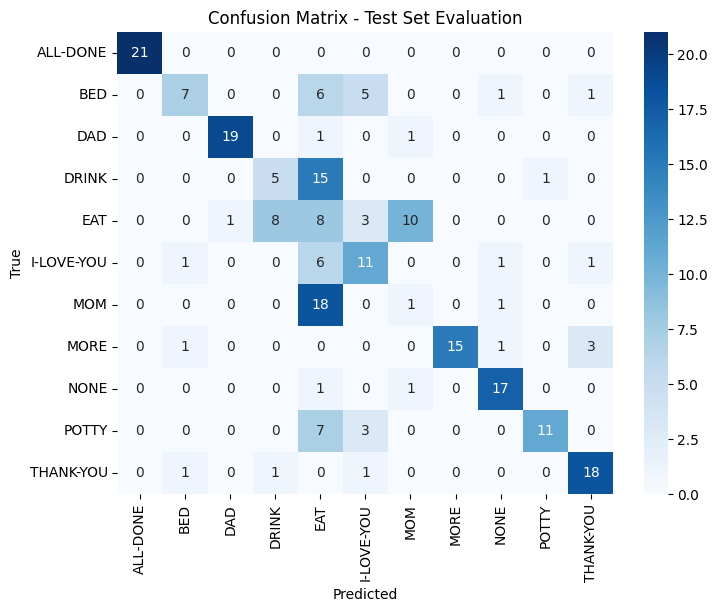

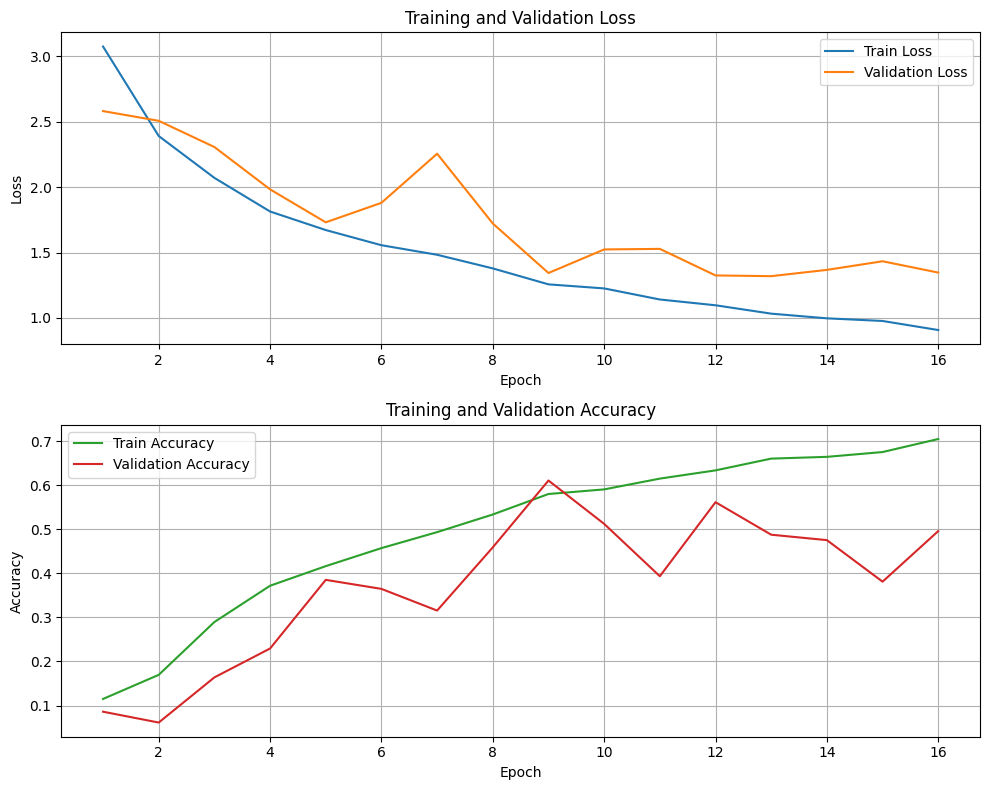

In [5]:
model_dev_v1 = Sequential([
    InputLayer(shape=(sequence_length, 2044)),  # Shape of the input

    GRU(256, return_sequences=True, kernel_regularizer=L1L2(1e-6, 1e-7)),
    LayerNormalization(),
    Dropout(0.3),
    
    # Bidirectional GRU layer
    Bidirectional(LSTM(256, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),

    # Another Bidirectional GRU layer (optional)
    Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=L2(1e-4))),
    LayerNormalization(),

    GRU(64, return_sequences=True, kernel_regularizer=L2(1e-4)),
    LayerNormalization(),
    Dropout(0.2),
    # Flatten the output before Dense layers
    Flatten(),

    # Fully connected layer
    Dense(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(1e-7))  # Output layer for classification

])
# from keras._tf_keras.keras.models import load_model
# model_dev_v1 = load_model(r"model_dev_v1_vr2.keras")

model_dev_v1.compile(optimizer=Nadam(learning_rate=1.0e-4, weight_decay=1e-6, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-12)	
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=10, threshold=0.2)

history_dev_1 = model_dev_v1.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=50,  # Adjust epochs as needed
    batch_size=64,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr, custom_early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model_dev_v1.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model_dev_v1.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history_dev_1, cm, class_labels)


# Test Loss: 1.494619369506836
# Test Accuracy: 0.4572649598121643

# Test Loss: 1.2893873453140259
# Test Accuracy: 0.5555555820465088

# Test Loss: 1.3994003534317017
# Test Accuracy: 0.5769230723381042

# Test Loss: 1.219314694404602
# Test Accuracy: 0.5683760643005371

In [8]:
# model_dev_v1.to_json()

model_dev_v1.metrics_names

['loss', 'compile_metrics']

In [9]:
# model_dev_v1.save("model_dev_v2_vr2.keras")

In [10]:
# model_dev_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 384)        │     2,355,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 384)        │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14, 96)         │        36,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 752)         │       997,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 752)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 4, 704)         │     2,335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 120)            │       297,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 120)            │           240 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197,688 (46.53 MB)

 Trainable params: 6,098,395 (23.26 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 6,098,397 (23.26 MB)